Loaded 3705 games.
Unique players: 30505


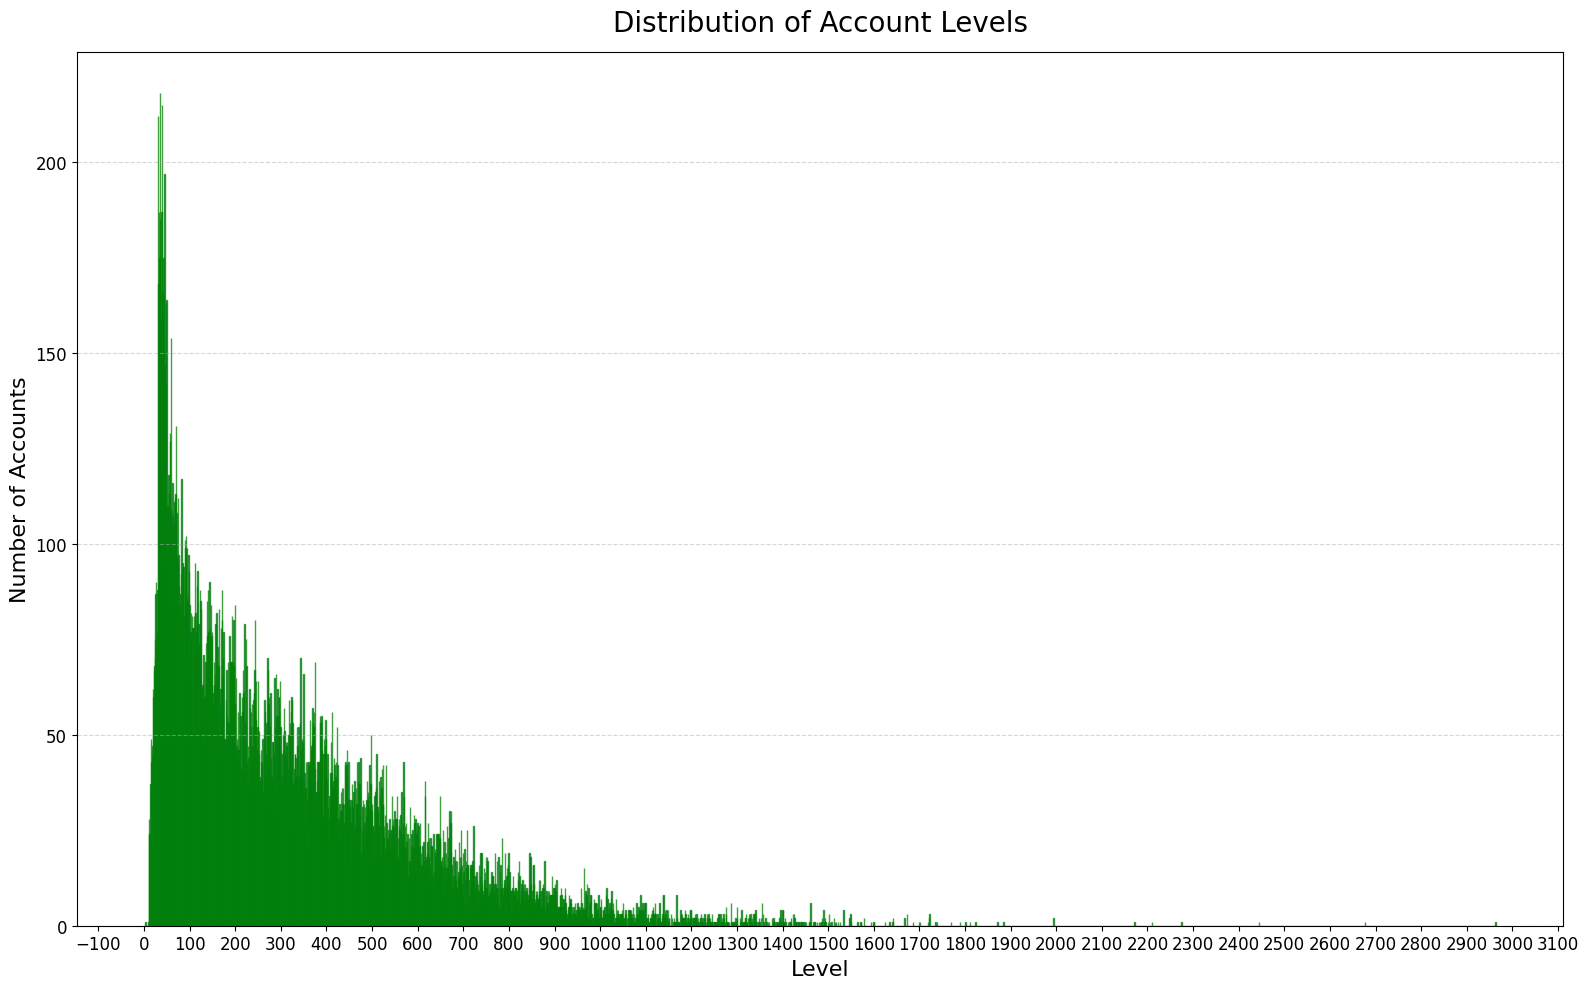

"Qnoxs #17165" Level: 2963
0.536986301369863


In [36]:
import json
import os
import math

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in os.listdir(game_path):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in games:
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")

def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

        

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level

plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

print(higher_level_winrate(games, 200))


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]
[0.5195787199567918, 0.5196443934614282, 0.5227272727272727, 0.5207042712748614, 0.5176019518996166, 0.5189873417721519, 0.5211267605633803, 0.5211937716262975, 0.5246971109040075, 0.5202224469160769, 0.5174482006543075, 0.5137231503579952, 0.5147347740667977, 0.5167259786476869, 0.5167055167055167, 0.5214408233276158, 0.5201499531396439, 0.5140771637122002, 0.5210466439135382, 0.5219573400250941, 0.536986301369863, 0.5347432024169184, 0.5370675453047776, 0.5251798561151079, 0.5303326810176126, 0.5343680709534369, 0.5361596009975063, 0.5405405405405406, 0.544891640866873, 0.5510204081632653, 0.555984555984556, 0.5550847457627118, 0.5622119815668203, 0.5647668393782384, 0.5642458100558659, 0.55151

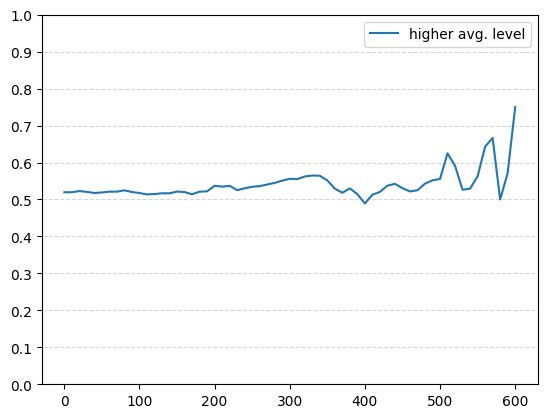

In [42]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_level_winrate(games, d)
    winrates_higher.append(higher_level_winrate(games, d))
    winrates_lower.append(lower_level_winrate(games, d))
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher avg. level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()